<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Cohort-Analysis" data-toc-modified-id="Cohort-Analysis-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Cohort Analysis</a></span><ul class="toc-item"><li><span><a href="#Example-of-Monthly-Cohort" data-toc-modified-id="Example-of-Monthly-Cohort-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Example of Monthly Cohort</a></span></li><li><span><a href="#Stack/Unstack" data-toc-modified-id="Stack/Unstack-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Stack/Unstack</a></span></li></ul></li><li><span><a href="#Further-Work" data-toc-modified-id="Further-Work-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Further Work</a></span></li><li><span><a href="#Reference" data-toc-modified-id="Reference-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Reference</a></span></li></ul></div>

In [1]:
# code for loading the format for the notebook
import os

# path : store the current path to convert back to it later
path = os.getcwd()
os.chdir(os.path.join('..', '..', 'notebook_format'))
from formats import load_style
load_style()

In [2]:
os.chdir(path)
# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
# 4. magic to enable retina (high resolution) plots
# https://gist.github.com/minrk/3301035
%matplotlib inline
%load_ext watermark
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

%watermark -a 'Ethen' -d -t -v -p numpy,pandas,seaborn,matplotlib

Ethen 2017-10-31 17:00:56 

CPython 3.5.2
IPython 6.2.1

numpy 1.13.3
pandas 0.20.3
seaborn 0.7.1
matplotlib 2.1.0


# Cohort Analysis

What is Cohort Analysis? and why is it valuable? To begin with, a cohort is a group of users who share something in common, be it their sign-up date, first purchase month, birth date, acquisition channel, etc. Cohort analysis is the method by which these groups are tracked over time, helping you spot trends, understand repeat behaviors (purchases, engagement, amount spent, etc.) and monitor your customer and revenue retention.

It’s common for cohorts to be created based on a customer’s first usage of the platform, where "usage" is dependent on your business’s key metrics. For Uber or Lyft, usage would be booking a trip through one of their apps. For GrubHub, it’s ordering some food. For AirBnB, it’s booking a stay. With these companies, a purchase is at their core, be it taking a trip or ordering dinner — their revenues are tied to their users’ purchase behavior. In others, a purchase is not central to the business model and the business is more interested in "engagement" with the platform. Facebook and Twitter are examples of this - are you visiting their sites every day? Are you performing some action on them - maybe a "like" on Facebook or a "favorite" on a tweet? Thus when building up a cohort analysis, it’s important to consider the relationship between the event or interaction you’re tracking and its relationship to your business model.

## Example of Monthly Cohort

Imagine we have the following dataset that has the standard purchase data with IDs for the order and user, order data and purhase amount. To create our monthly cohort, we'll first have to:

- Convert our date to a monthly-time basis.
- Determine the user's cohort group based on their first order, which is the year and month in which the user's first purchase occurred.

In [3]:
df = pd.read_csv('relay-foods.csv')
df.head()

,OrderId,OrderDate,UserId,TotalCharges,CommonId,PupId,PickupDate
0,262,1/11/09,47,$50.67,TRQKD,2,1/12/09
1,278,1/20/09,47,$26.60,4HH2S,3,1/20/09
2,294,2/3/09,47,$38.71,3TRDC,2,2/4/09
3,301,2/6/09,47,$53.38,NGAZJ,2,2/9/09
4,302,2/6/09,47,$14.28,FFYHD,2,2/9/09


In [4]:
def parse_dmy(s):
    """
    convert string to datetime format
    
    References
    ----------
    http://chimera.labs.oreilly.com/books/1230000000393/ch03.html#_discussion_55
    """
    month, day, year = s.split('/')
    return datetime(int('20' + year), int(month), int(day))


# remove the $ sign from the TotalCharges column 
# and convert it to float
df['TotalCharges'] = (df['TotalCharges'].
                      apply(lambda x: x.replace('$', '')).
                      astype('float'))

# strip out the year and month into a new column
df['OrderDate'] = df['OrderDate'].apply(parse_dmy)
df['OrderPeriod'] = df['OrderDate'].apply(lambda x: x.strftime('%Y-%m'))
df.head()

,OrderId,OrderDate,UserId,TotalCharges,CommonId,PupId,PickupDate,OrderPeriod
0,262,2009-01-11,47,50.67,TRQKD,2,1/12/09,2009-01
1,278,2009-01-20,47,26.60,4HH2S,3,1/20/09,2009-01
2,294,2009-02-03,47,38.71,3TRDC,2,2/4/09,2009-02
3,301,2009-02-06,47,53.38,NGAZJ,2,2/9/09,2009-02
4,302,2009-02-06,47,14.28,FFYHD,2,2/9/09,2009-02


In [5]:
# convert each user id into their cohort group
df = df.set_index('UserId')
df['CohortGroup'] = (df.
                     groupby(level = 0)['OrderDate'].min().
                     apply(lambda x: x.strftime('%Y-%m')))
df = df.reset_index()
df.head()

,UserId,OrderId,OrderDate,TotalCharges,CommonId,PupId,PickupDate,OrderPeriod,CohortGroup
0,47,262,2009-01-11,50.67,TRQKD,2,1/12/09,2009-01,2009-01
1,47,278,2009-01-20,26.60,4HH2S,3,1/20/09,2009-01,2009-01
2,47,294,2009-02-03,38.71,3TRDC,2,2/4/09,2009-02,2009-01
3,47,301,2009-02-06,53.38,NGAZJ,2,2/9/09,2009-02,2009-01
4,47,302,2009-02-06,14.28,FFYHD,2,2/9/09,2009-02,2009-01


Since we're looking at monthly cohorts, we need to aggregate users, orders, and amount spent by the CohortGroup within each month (OrderPeriod). After that, we wish to look at how each cohort has behaved in the months following their first purchase, so we'll need to index each cohort with respect to their first purchase month. For example, CohortPeriod = 1 will be the cohort's first month, CohortPeriod = 2 is their second, and so on. This allows us to compare cohorts across various stages of their lifetime.

In [6]:
grouped = df.groupby(['CohortGroup', 'OrderPeriod'])

# count the unique users, orders, and total revenue per Group + Period
cohorts = grouped.agg({'UserId': pd.Series.nunique,
                       'OrderId': pd.Series.nunique,
                       'TotalCharges': np.sum})

# make the column names more meaningful
renaming = {'UserId': 'TotalUsers', 'OrderId': 'TotalOrders'}
cohorts = cohorts.rename(columns = renaming)
cohorts.head()

TotalOrders  TotalUsers  TotalCharges
CohortGroup OrderPeriod                                       
2009-01     2009-01               30          22       1850.26
            2009-02               25           8       1351.07
            2009-03               26          10       1357.36
            2009-04               28           9       1604.50
            2009-05               26          10       1575.63

In [7]:
def cohort_period(df):
    """
    Creates a `CohortPeriod` column, 
    which is the Nth period based on the user's first purchase.
    """
    df['CohortPeriod'] = np.arange(len(df)) + 1
    return df


cohorts = cohorts.groupby(level = 'CohortGroup').apply(cohort_period)
cohorts.head()

TotalOrders  TotalUsers  TotalCharges  CohortPeriod
CohortGroup OrderPeriod                                                     
2009-01     2009-01               30          22       1850.26             1
            2009-02               25           8       1351.07             2
            2009-03               26          10       1357.36             3
            2009-04               28           9       1604.50             4
            2009-05               26          10       1575.63             5

We're now half way done, before we proceed on with the process, we will do some sanity checking to make sure that we did everything right by performing some simple testing. We'll test data points from the original DataFrame with their corresponding values in the new cohorts DataFrame to make sure all our data transformations worked as expected. As long as none of these raise an exception, we're good.

In [8]:
# unit test code chunk
mask = (df['CohortGroup'] == '2009-01') & (df['OrderPeriod'] == '2009-01')
x = df[mask]
y = cohorts.loc[('2009-01', '2009-01')]

assert(x['UserId'].nunique() == y['TotalUsers'])
assert(x['TotalCharges'].sum() == y['TotalCharges'])
assert(x['OrderId'].nunique() == y['TotalOrders'])

To calculate the user retention by cohort group, We want to look at the percentage change of each `CohortGroup` over time -- not the absolute change. To do this, we'll first need to create a pandas Series containing each `CohortGroup` and its size.

In [9]:
# convert the CohortPeriod as indices instead of OrderPeriod
cohorts = cohorts.reset_index()
cohorts = cohorts.set_index(['CohortGroup', 'CohortPeriod'])
cohorts.head()

OrderPeriod  TotalOrders  TotalUsers  TotalCharges
CohortGroup CohortPeriod                                                   
2009-01     1                2009-01           30          22       1850.26
            2                2009-02           25           8       1351.07
            3                2009-03           26          10       1357.36
            4                2009-04           28           9       1604.50
            5                2009-05           26          10       1575.63

In [10]:
# create a Series holding the total size of each CohortGroup
cohorts_size = cohorts['TotalUsers'].groupby(level = 'CohortGroup').first()
cohorts_size.head()

CohortGroup
2009-01    22
2009-02    15
2009-03    13
2009-04    39
2009-05    50
Name: TotalUsers, dtype: int64

Now, we'll need to divide the `TotalUsers` values in cohorts by `cohort_size`. Since DataFrame operations are performed based on the indices of the objects, we'll use `unstack` on our cohorts DataFrame to create a matrix where each column represents a `CohortGroup` and each row is the `CohortPeriod` corresponding to that group.

## Stack/Unstack

In case you're not familiar with what `unstack` and stack does:

Stacking a DataFrame means moving (also rotating or pivoting) the innermost column index to become the innermost row index. The inverse operation is called unstacking. It means moving the innermost row index to become the innermost column index. The following diagram depicts the operations:

<img src="stack_unstack.png" width="70%" height="70%">

In [11]:
# applying it 
user_retention = (cohorts['TotalUsers'].
                  unstack('CohortGroup').
                  divide(cohorts_size, axis = 1))
user_retention.head()

CohortGroup,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03
CohortPeriod,,,,,,,,,,,,,,,
1,1.000000,1.000000,1.000000,1.000000,1.00,1.00000,1.00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00,1.0
2,0.363636,0.200000,0.307692,0.333333,0.26,0.46875,0.46,0.354839,0.405405,0.314815,0.246154,0.261538,0.526316,0.19,NaN
3,0.454545,0.333333,0.384615,0.256410,0.24,0.28125,0.26,0.290323,0.378378,0.222222,0.200000,0.276923,0.273684,NaN,NaN
4,0.409091,0.066667,0.307692,0.333333,0.10,0.18750,0.20,0.225806,0.216216,0.240741,0.223077,0.107692,NaN,NaN,NaN
5,0.454545,0.266667,0.076923,0.153846,0.08,0.21875,0.22,0.193548,0.351351,0.240741,0.100000,NaN,NaN,NaN,NaN


The resulting DataFrame, `user_retention`, contains the percentage of users from the cohort purchasing within the given period. For instance, 38.4% of users in the 2009-03 cohort purchased again in month 3 (which would be May 2009).

Finally, we can plot the cohorts over time in an effort to spot behavioral differences or similarities. Two common cohort charts are line graphs and heatmaps, both of which are shown below.

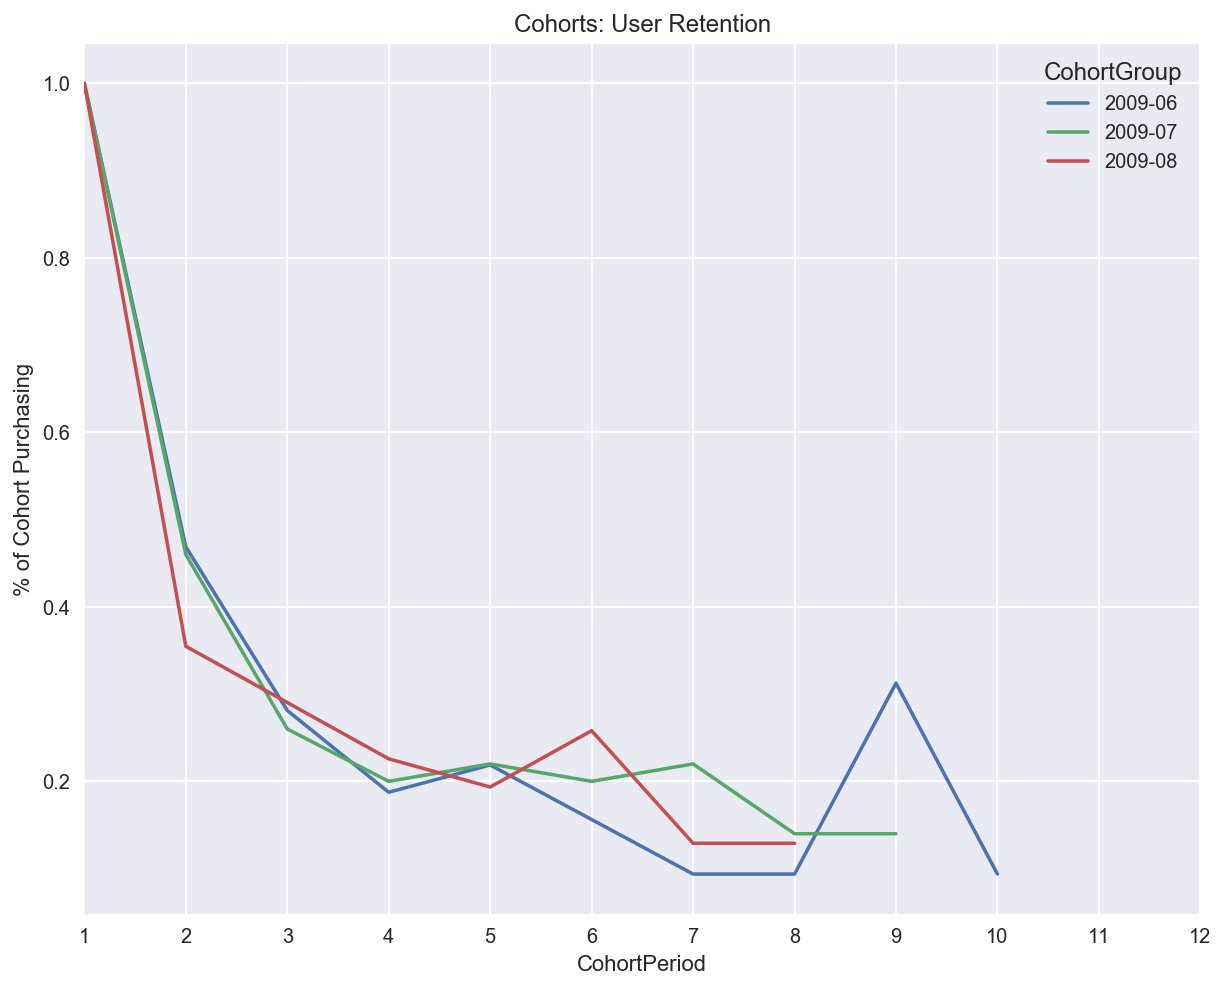

In [12]:
# change default figure and font size
plt.rcParams['figure.figsize'] = 10, 8
plt.rcParams['font.size'] = 12


user_retention[['2009-06', '2009-07', '2009-08']].plot()
plt.title('Cohorts: User Retention')
plt.xticks(range(1, 13))
plt.xlim(1, 12)
plt.ylabel('% of Cohort Purchasing')
plt.show()

Notice that the first period of each cohort is always 100% -- this is because our cohorts are based on each user's first purchase. Meaning everyone in the cohort should have made a purchase in the first month.

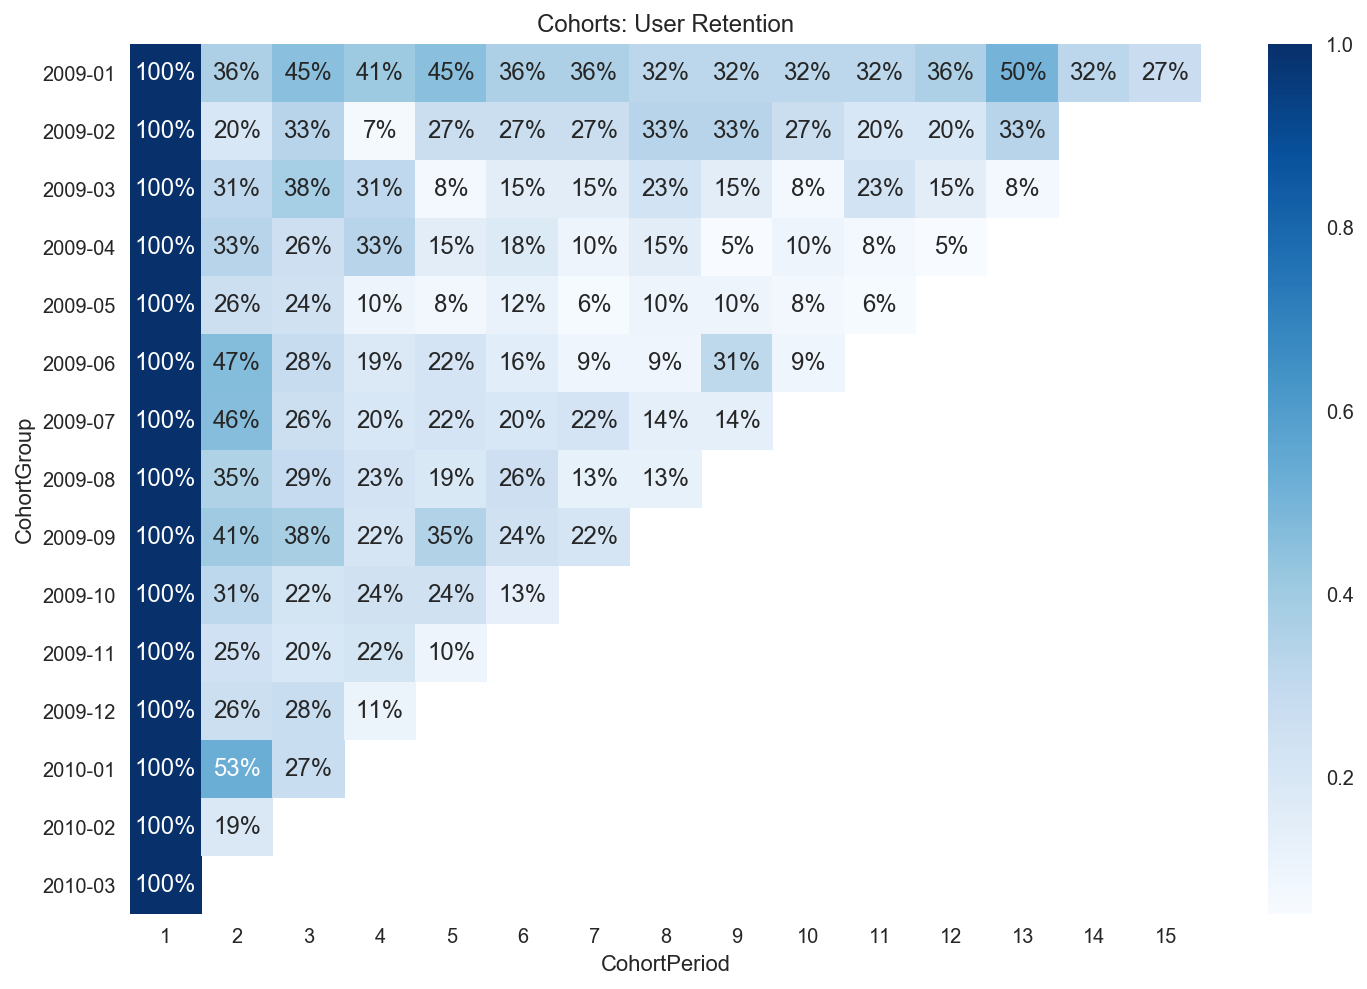

In [13]:
sns.set(style = 'white')

plt.figure(figsize = (12, 8))
plt.title('Cohorts: User Retention')
sns.heatmap(user_retention.T,
            cmap = plt.cm.Blues,
            mask = user_retention.T.isnull(),  # data will not be shown where it's True
            annot = True,  # annotate the text on top
            fmt = '.0%')  # string formatting when annot is True
plt.show()

Unsurprisingly, we can see from the above chart that fewer users tend to purchase as time goes on. However, we can also see that the 2009-01 cohort is the strongest, which enables us to ask targeted questions about this cohort compared to others -- What other attributes (besides first purchase month) do these users share which might be causing them to stick around? How were the majority of these users acquired? Was there a specific marketing campaign that brought them in? Did they take advantage of a promotion at sign-up? The answers to these questions would inform future marketing and product efforts.

# Further Work

User retention is only one way of using cohorts to look at your business — we could have also looked at revenue retention. That is, the percentage of each cohort’s first month revenue returning in subsequent periods. User retention is important, but we shouldn’t lose sight of the revenue each cohort is bringing in (and how much of it is returning).

To sum it up, cohort analysis can be valuable when it comes to understanding your business's health and "stickiness" - the loyalty of your customers. Stickiness is critical since it’s far cheaper and easier to keep a current customer than to acquire a new one. For startups, it’s also a key indicator of product-market fit.

Additionally, your product evolves over time. New features are added and removed, the design changes, etc. Observing individual groups over time is a starting point to understanding how these changes affect user behavior. It’s also a good way to visualize your user retention/churn as well as formulating a basic understanding of their lifetime value.

# Reference

- [Blog: Cohort Analysis with Python](http://www.gregreda.com/2015/08/23/cohort-analysis-with-python/)
- [Blog: Pivot, Pivot-Table, Stack and Unstack explained with Pictures](http://nikgrozev.com/2015/07/01/reshaping-in-pandas-pivot-pivot-table-stack-and-unstack-explained-with-pictures/)